# Geomagnetic Ground Observatory Data

> Authors: Luca Mariani, Clemens Kloss
>
> Abstract: Demonstrates ground observatory data by direct access to the  BGS FTP server (AUX_OBS dataset). Note that in the future there will be a VirES-based access method (work in progress).

<a id="top"/>

## Contents

- [Settings and functions](#settings)
- [Hourly mean values](#obs)
    - [Read data from ASCII files](#obs-read-ascii)
    - [Read data from multiple files](#obs-multifiles)
    - [Examples](#obs-examples)
- [Minute and second mean values](#obsms)
    - [Read data from CDF files](#obsms-read-cdf)
    - [Read data from multiple files](#obsms-multifiles)

In [1]:
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

2020-05-10T15:49:11+00:00

CPython 3.7.6
IPython 7.11.1

viresclient 0.6.1
pandas 0.25.3
xarray 0.15.0
matplotlib 3.1.2


In [2]:
# Python standard library
import os
import re
from contextlib import closing
from datetime import datetime
from ftplib import FTP
from pathlib import Path
from tempfile import TemporaryFile
from zipfile import ZipFile

# Extra libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cdflib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from viresclient import SwarmRequest

<a id="settings" />

## Settings and functions

[[TOP]](#top)

First we define a number of functions to enable convenient searching, downloading and reading from the FTP server.

In [3]:
# FTP server
HOST = 'ftp.nerc-murchison.ac.uk'

# Local directories (update paths according to your environment)
OBS_HOUR_LOCAL_DIR = Path('~/data/AUX_OBS/hour').expanduser()
OBS_MINUTE_LOCAL_DIR = Path('~/data/AUX_OBS/minute').expanduser()
OBS_SECOND_LOCAL_DIR = Path('~/data/AUX_OBS/second').expanduser()

# Create directories to use
os.makedirs(OBS_HOUR_LOCAL_DIR, exist_ok=True)
os.makedirs(OBS_MINUTE_LOCAL_DIR, exist_ok=True)
os.makedirs(OBS_SECOND_LOCAL_DIR, exist_ok=True)


def search(obstype, start_date=None, end_date=None):
    """Search OBS data file on the FTP server.

    Parameters
    ----------
    obstype : str
        OBS file type: `hour`, `minute`, `second`.
    start_date : str or numpy.datetime64
        lower bound of the time interval (default: no time interval).
    stop_date : str or numpy.datetime64
        upper bound of the time interval (default: no time interval).
    
    Returns
    -------
    list(str)
        OBS data files.
        
    Raises
    ------
    ValueError
        if `obstype` is not valid.
    ftplib.all_errors
        in case of FTP errors.
    
    """

    OBS_HOUR_DIR = '/geomag/Swarm/AUX_OBS/hour'
    OBS_MINUTE_DIR = '/geomag/Swarm/AUX_OBS/minute'
    OBS_SECOND_DIR = '/geomag/Swarm/AUX_OBS/second'
    PATTERN = re.compile(
        r'SW_OPER_AUX_OBS[_MS]2__(?P<start>\d{8}T\d{6})_'
        r'(?P<stop>\d{8}T\d{6})_\d{4}\.ZIP$'
    )
    MINDATE = np.datetime64('0000', 's')
    MAXDATE = np.datetime64('9999', 's')
    
    def _callback(line, result, start_date, end_date):
        if line[0] == '-':
            match = PATTERN.match(line[56:])
            if match:
                start, stop = match.groupdict().values()
                start = np.datetime64(datetime.strptime(start, '%Y%m%dT%H%M%S'))
                stop = np.datetime64(datetime.strptime(stop, '%Y%m%dT%H%M%S'))
                if end_date >= start and start_date <= stop:
                    result.append(line[56:])

    start_date = MINDATE if start_date is None else np.datetime64(start_date)
    end_date = MAXDATE if end_date is None else np.datetime64(end_date)
    paths = {
        'hour': OBS_HOUR_DIR,
        'minute': OBS_MINUTE_DIR,
        'second': OBS_SECOND_DIR
    }
    if obstype not in paths:
        raise ValueError(
            f'obstype must be hour, minute or second, not {obstype}'
        )

    result = []
    with FTP(HOST) as ftp:
        ftp.login()
        ftp.dir(paths[obstype], lambda line: _callback(line, result, start_date, end_date))
    return [f'{paths[obstype]}/{name}' for name in sorted(result)]


def loacal_search(obstype, start_date=None, end_date=None):
    """Search OBS data file on local filesystem.

    Parameters
    ----------
    obstype : str
        OBS file type: `hour`, `minute`, `second`.
    start_date : str or numpy.datetime64
        lower bound of the time interval (default: no time interval).
    stop_date : str or numpy.datetime64
        upper bound of the time interval (default: no time interval).
    
    Returns
    -------
    list(pathlib.Path)
        OBS data files.
        
    Raises
    ------
    ValueError
        if `obstype` is not valid.
    
    """

    PATTERN = re.compile(
        r'SW_OPER_AUX_OBS[_MS]2__(?P<start>\d{8}T\d{6})_'
        r'(?P<stop>\d{8}T\d{6})_\d{4}\.\w{3}$'
    )
    MINDATE = np.datetime64('0000', 's')
    MAXDATE = np.datetime64('9999', 's')
    
    start_date = MINDATE if start_date is None else np.datetime64(start_date)
    end_date = MAXDATE if end_date is None else np.datetime64(end_date)
    paths = {
        'hour': OBS_HOUR_LOCAL_DIR,
        'minute': OBS_MINUTE_LOCAL_DIR,
        'second': OBS_SECOND_LOCAL_DIR
    }
    if obstype not in paths:
        raise ValueError(
            f'obstype must be hour, minute or second, not {obstype}'
        )

    result = []
    for file in (elm for elm in paths[obstype].iterdir() if elm.is_file()):
        match = PATTERN.match(file.name)
        if match:
            start, stop = match.groupdict().values()
            start = np.datetime64(datetime.strptime(start, '%Y%m%dT%H%M%S'))
            stop = np.datetime64(datetime.strptime(stop, '%Y%m%dT%H%M%S'))
            if end_date >= start and start_date <= stop:
                result.append(file)
    return sorted(result)


def download(files, outdir='', show_progress=True):
    """Download files from the FTP server.

    Parameters
    ----------
    outdir : str or os.PathLike
        output directory (default: current directory).
    files : collections.abc.Iterable(str)
        path(s) of the file(s) to be downloaded
    
    Returns
    -------
    list(pathlib.Path)
        list of downloaded files.
        
    Raises
    ------
    ftplib.all_errors
        in case of FTP errors.
    
    """
    def _callback(data, fh, pbar):
        pbar.update(len(data))
        fh.write(data)

    outdir = Path(outdir)
    downloaded = []
    with FTP(HOST) as ftp:
        ftp.login()
        for file in files:
            file = str(file)
            basename = file.split('/')[-1]
            with TemporaryFile(dir=outdir) as tmp:
                with tqdm(total=ftp.size(file), unit='B',
                          unit_scale=True, desc=basename,
                          disable=not show_progress) as pbar:
                    ftp.retrbinary(f'RETR {file}', callback=lambda x: _callback(x, tmp, pbar))
                    with ZipFile(tmp) as zf:
                        hdr = Path(basename).with_suffix('.HDR').name
                        datafile = [elm for elm in zf.namelist()if elm != hdr][0]
                        outfile = zf.extract(datafile, outdir)
                        downloaded.append(Path(outfile))
    return downloaded


def ascii_to_pandas(file):
    """Convert an OBS ASCII file to a pandas DataFrame.
    
    Parameters
    ----------
    file : str or os.PathLike
        OBS ASCII file.
    
    Returns
    -------
    pandas.DataFrame
        data contained in the OBS ASCII file.

    """
    df = pd.read_csv(
        file,
        comment='#',
        delim_whitespace=True,
        names = ['IAGA_code', 'Latitude', 'Longitude', 'Radius',
                 'yyyy', 'mm', 'dd', 'UT', 'B_N', 'B_E', 'B_C'],
        parse_dates={'Timestamp': [4, 5, 6]},
        infer_datetime_format=True
    )
    df['Timestamp'] = df['Timestamp'] + pd.to_timedelta(df['UT'], 'h')
    df.drop(columns='UT', inplace=True)
    df.set_index('Timestamp', inplace=True)
    return df


def cdf_to_pandas(file):
    """Convert an OBS CDF file to a pandas DataFrame.
    
    Parameters
    ----------
    file : str or os.PathLike
        OBS CDF file.
    
    Returns
    -------
    pandas.DataFrame
        data contained in the OBS CDF file.

    """
    with closing(cdflib.cdfread.CDF(file)) as data:
        ts = pd.DatetimeIndex(
            cdflib.cdfepoch.encode(data.varget('Timestamp'), iso_8601=True),
            name='Timestamp'
        )
        df = pd.DataFrame(
            {
                'IAGA_code': data.varget('IAGA_code')[:,0,0],
                'Latitude': data.varget('Latitude'),
                'Longitude': data.varget('Longitude'),
                'Radius': data.varget('Radius'),
                'B_N': data.varget('B_NEC')[:,0],
                'B_E': data.varget('B_NEC')[:,1],
                'B_C': data.varget('B_NEC')[:,2]
            },
            index=ts
        )
    return df


def download_obslist(outdir=''):
    """Search observatory list file on the FTP server.

    Parameters
    ----------
    outdir : str or os.PathLike
        output directory (default: current directory).

    Returns
    -------
    str
        Observatory list file.
        
    Raises
    ------
    ftplib.all_errors
        in case of FTP errors.
    
    """

    OBS_HOUR_DIR = '/geomag/Swarm/AUX_OBS/hour'
    
    def _callback(line, result):
        if line[0] == '-':
            match = re.match('obslist.+_gd\.all$', line[56:])
            if match:
                result.append(line[56:])

    outdir = Path(outdir)
    files = []
    with FTP(HOST) as ftp:
        ftp.login()
        ftp.dir(OBS_HOUR_DIR, lambda line: _callback(line, files))
        remote_obslist_file = f'{OBS_HOUR_DIR}/{files[0]}'
        local_obslist_file = outdir / files[0]
        with local_obslist_file.open('w') as fh:
            ftp.retrlines(f'RETR {remote_obslist_file}', lambda line: print(line, file=fh))
    return local_obslist_file
        

def read_obslist(file):
    """Convert observatory list  ASCII file to a pandas DataFrame.
    
    Parameters
    ----------
    file : str or os.PathLike
        observatory list ASCII file.
    
    Returns
    -------
    pandas.DataFrame
        data contained in the observatory list ASCII file.

    """
    df = pd.read_csv(
        file,
        delim_whitespace=True,
        names = ['IAGA_code', 'Latitude', 'Longitude', 'Altitude'],
    )
    return df

<a id="obs" />

## Hourly mean values

[[TOP]](#top)

Hourly means hosted at:
- ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/hour/

Processing methodology:
- Macmillan, S., Olsen, N. Observatory data and the Swarm mission. Earth Planet Sp 65, 15 (2013). https://doi.org/10.5047/eps.2013.07.011

<a id="obs-read-ascii" />

### Read data from ASCII files

[[TOP]](#top)

Use the `search()` function (see [Settings and functions](#settings)) to search OBS hourly data from 2018-01-01T00:00:00 to 2019-12-31T23:59:59 on the FTP server:

In [4]:
result = search('hour', '2018-01-01', '2019-12-31T23:59:59')
result

['/geomag/Swarm/AUX_OBS/hour/SW_OPER_AUX_OBS_2__20180101T000000_20181231T235959_0122.ZIP',
 '/geomag/Swarm/AUX_OBS/hour/SW_OPER_AUX_OBS_2__20190101T000000_20191231T235959_0122.ZIP']

Use the `download()` function (see [Settings and functions](#settings)) to download data:

In [5]:
downloaded = download(result, outdir=OBS_HOUR_LOCAL_DIR)
downloaded

SW_OPER_AUX_OBS_2__20180101T000000_20181231T235959_0122.ZIP: 100%|██████████| 6.04M/6.04M [00:03<00:00, 1.68MB/s]
SW_OPER_AUX_OBS_2__20190101T000000_20191231T235959_0122.ZIP: 100%|██████████| 4.75M/4.75M [00:02<00:00, 1.73MB/s]


[PosixPath('/home/jovyan/data/AUX_OBS/hour/SW_OPER_AUX_OBS_2__20180101T000000_20181231T235959_0122.txt'),
 PosixPath('/home/jovyan/data/AUX_OBS/hour/SW_OPER_AUX_OBS_2__20190101T000000_20191231T235959_0122.txt')]

Select one of the AUX_OBS_2_ files (e.g. the first one):

In [6]:
file1 = downloaded[0]
file1

PosixPath('/home/jovyan/data/AUX_OBS/hour/SW_OPER_AUX_OBS_2__20180101T000000_20181231T235959_0122.txt')

Read ASCII file and convert data to a `pandas.DataFrame`:

In [7]:
df1 = pd.read_csv(
    file1,
    comment='#',
    delim_whitespace=True,
    names = ['IAGA_code', 'Latitude', 'Longitude',
             'Radius', 'yyyy', 'mm', 'dd', 'UT', 'B_N', 'B_E', 'B_C'],
    parse_dates={'Timestamp': [4, 5, 6]},
    infer_datetime_format=True
)
df1['Timestamp'] = df1['Timestamp'] + pd.to_timedelta(df1['UT'], 'h')
df1.drop(columns='UT', inplace=True)
df1.set_index('Timestamp', inplace=True)

df1

,IAGA_code,Latitude,Longitude,Radius,B_N,B_E,B_C
Timestamp,,,,,,,
2018-01-01 00:30:00,ABG1,18.517,72.867,6375.977,38137.1,236.0,20211.4
2018-01-01 01:30:00,ABG1,18.517,72.867,6375.977,38140.1,232.0,20209.4
2018-01-01 02:30:00,ABG1,18.517,72.867,6375.977,38144.1,227.0,20211.4
2018-01-01 03:30:00,ABG1,18.517,72.867,6375.977,38160.1,228.0,20216.4
2018-01-01 04:30:00,ABG1,18.517,72.867,6375.977,38157.1,230.0,20221.4
...,...,...,...,...,...,...,...
2018-12-31 19:30:00,WNG0,53.566,9.067,6364.320,18032.5,941.0,46356.1
2018-12-31 20:30:00,WNG0,53.566,9.067,6364.320,18030.5,942.0,46355.0
2018-12-31 21:30:00,WNG0,53.566,9.067,6364.320,18031.5,946.0,46356.1


For more information on `pandas.Dataframe` see: https://pandas.pydata.org/docs/reference/frame.

The same result can be obtained with the `ascii_to_pandas()` function (see [Settings and functions](#settings)).

In [8]:
new = ascii_to_pandas(file1)
new

,IAGA_code,Latitude,Longitude,Radius,B_N,B_E,B_C
Timestamp,,,,,,,
2018-01-01 00:30:00,ABG1,18.517,72.867,6375.977,38137.1,236.0,20211.4
2018-01-01 01:30:00,ABG1,18.517,72.867,6375.977,38140.1,232.0,20209.4
2018-01-01 02:30:00,ABG1,18.517,72.867,6375.977,38144.1,227.0,20211.4
2018-01-01 03:30:00,ABG1,18.517,72.867,6375.977,38160.1,228.0,20216.4
2018-01-01 04:30:00,ABG1,18.517,72.867,6375.977,38157.1,230.0,20221.4
...,...,...,...,...,...,...,...
2018-12-31 19:30:00,WNG0,53.566,9.067,6364.320,18032.5,941.0,46356.1
2018-12-31 20:30:00,WNG0,53.566,9.067,6364.320,18030.5,942.0,46355.0
2018-12-31 21:30:00,WNG0,53.566,9.067,6364.320,18031.5,946.0,46356.1


Compare the two data frames:

In [9]:
pd.testing.assert_frame_equal(df1, new)

Example: get minimum and maximum dates:

In [10]:
df1.index.min(), df1.index.max()

(Timestamp('2018-01-01 00:30:00'), Timestamp('2018-12-31 23:30:00'))

Example: get list of observatories (IAGA codes) stored in the files:

In [11]:
df1['IAGA_code'].unique()

array(['ABG1', 'ABK0', 'ARS0', 'ASC0', 'ASP0', 'BDV0', 'BEL0', 'BFO0',
       'BJN1', 'BOU0', 'BOX0', 'BRW0', 'CKI0', 'CLF0', 'CMO3', 'CNB0',
       'CSY1', 'CTA0', 'CYG0', 'DLT0', 'DOB1', 'DOU0', 'EBR0', 'ESK0',
       'EYR0', 'FCC0', 'FRD0', 'FRN0', 'FUR0', 'GCK0', 'GDH2', 'GNG0',
       'GUA0', 'HAD0', 'HBK0', 'HER0', 'HLP0', 'HON3', 'HRB0', 'HRN0',
       'HYB0', 'IQA1', 'IRT2', 'IZN0', 'JCO0', 'KAK0', 'KDU0', 'KEP0',
       'KHB0', 'KMH1', 'KNY0', 'KOU0', 'LER0', 'LON0', 'LRM0', 'LRV0',
       'LYC0', 'LZH1', 'MAB0', 'MAW0', 'MBO0', 'MCQ0', 'MEA0', 'MGD0',
       'MMB0', 'NAQ0', 'NEW0', 'NGK0', 'NMP1', 'NVS0', 'OTT0', 'PET2',
       'PHU1', 'PST0', 'RES0', 'SBA0', 'SBL0', 'SFS2', 'SHU0', 'SIT2',
       'SPT0', 'STJ0', 'SUA1', 'TAM0', 'THL0', 'THY0', 'TRO0', 'TSU0',
       'TUC2', 'UPS0', 'VIC0', 'VNA0', 'VOS3', 'WIC0', 'WNG0'],
      dtype=object)

<a id="obs-multifiles" />

### Read data from multiple files

[[TOP]](#top)

Pandas dataframes can be concatenated to represent data obtained from more than one file. E.g. read data from the next AUX_OBS_2_ file:

In [12]:
file2 = downloaded[1]
df2 = ascii_to_pandas(file2)
df2

,IAGA_code,Latitude,Longitude,Radius,B_N,B_E,B_C
Timestamp,,,,,,,
2019-01-01 00:30:00,ABK0,68.218,18.817,6360.064,11160.6,1811.1,52112.6
2019-01-01 01:30:00,ABK0,68.218,18.817,6360.064,11153.4,1813.1,52107.4
2019-01-01 02:30:00,ABK0,68.218,18.817,6360.064,11161.0,1818.5,52101.2
2019-01-01 03:30:00,ABK0,68.218,18.817,6360.064,11165.7,1818.2,52105.6
2019-01-01 04:30:00,ABK0,68.218,18.817,6360.064,11167.8,1814.9,52102.9
...,...,...,...,...,...,...,...
2019-04-30 19:30:00,WIC0,47.742,15.867,6367.484,20868.8,1608.6,43940.2
2019-04-30 20:30:00,WIC0,47.742,15.867,6367.484,20867.7,1621.0,43940.2
2019-04-30 21:30:00,WIC0,47.742,15.867,6367.484,20866.2,1611.0,43940.4


The two dataframes can be concatenated using the `pandas.concat()` function (for more information see: https://pandas.pydata.org/docs/reference/api/pandas.concat.html#pandas.concat):

In [13]:
concatenated = pd.concat([df1, df2])
concatenated.sort_values(by=['IAGA_code', 'Timestamp'], inplace=True)

concatenated.index.min(), concatenated.index.max()

(Timestamp('2018-01-01 00:30:00'), Timestamp('2019-12-31 23:30:00'))

In [14]:
concatenated

,IAGA_code,Latitude,Longitude,Radius,B_N,B_E,B_C
Timestamp,,,,,,,
2018-01-01 00:30:00,ABG1,18.517,72.867,6375.977,38137.1,236.0,20211.4
2018-01-01 01:30:00,ABG1,18.517,72.867,6375.977,38140.1,232.0,20209.4
2018-01-01 02:30:00,ABG1,18.517,72.867,6375.977,38144.1,227.0,20211.4
2018-01-01 03:30:00,ABG1,18.517,72.867,6375.977,38160.1,228.0,20216.4
2018-01-01 04:30:00,ABG1,18.517,72.867,6375.977,38157.1,230.0,20221.4
...,...,...,...,...,...,...,...
2018-12-31 19:30:00,WNG0,53.566,9.067,6364.320,18032.5,941.0,46356.1
2018-12-31 20:30:00,WNG0,53.566,9.067,6364.320,18030.5,942.0,46355.0
2018-12-31 21:30:00,WNG0,53.566,9.067,6364.320,18031.5,946.0,46356.1


<a id="obs-examples"/>

### Examples

[[TOP]](#top)

Plot hourly mean values on a map:

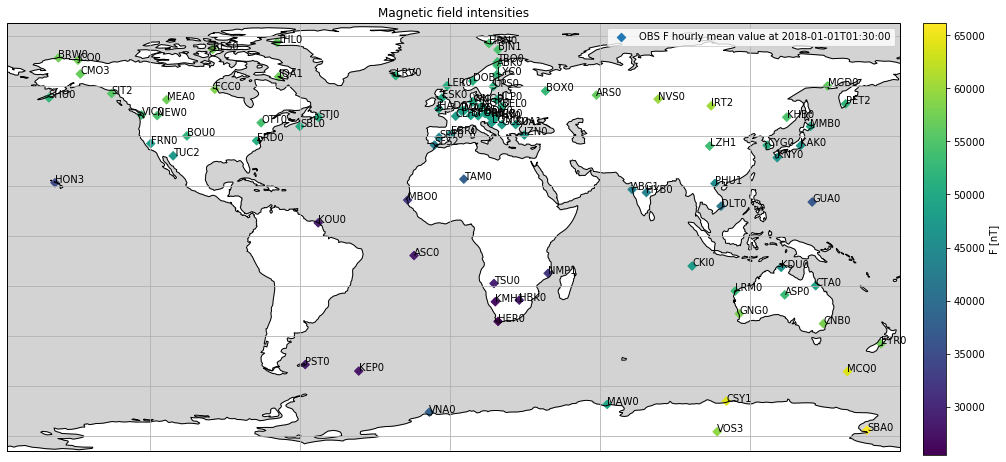

In [15]:
df = ascii_to_pandas(file1)

# Add F column
df['F'] = np.linalg.norm(df[['B_N', 'B_E', 'B_C']], axis=1)

# Select date
date = '2018-01-01T01:30:00'

fig = plt.figure(figsize=(16, 10))

# Draw map
ax = plt.subplot2grid((1, 1), (0, 0), projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
ax.gridlines()

# Plot observatory measurements at date
cm = ax.scatter(
    df[date]['Longitude'], df[date]['Latitude'], c=df[date]['F'],
    marker='D', transform=ccrs.PlateCarree(),
    label=f'OBS F hourly mean value at {date}'
)

# Add IAGA codes
for row in df[date].itertuples():
    ax.annotate(
        row.IAGA_code, (row.Longitude, row.Latitude),
        xycoords=ccrs.PlateCarree()._as_mpl_transform(ax)
    )

# Set title and legendbb
plt.title('Magnetic field intensities')
plt.legend()

# Add colorbar
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
plt.colorbar(cm, cax=cax, label='F [nT]')

plt.show()

Read list of all observatories (use the `download_obslist()` and `read_obslist()` functions defined in [Settings and functions](#settings)):

In [16]:
obslist = download_obslist(outdir=OBS_HOUR_LOCAL_DIR)
obslist

PosixPath('/home/jovyan/data/AUX_OBS/hour/obslist19002020_0122_gd.all')

In [17]:
obs = read_obslist(obslist)
obs

,IAGA_code,Latitude,Longitude,Altitude
0,AAA0,43.250,76.917,1.300
1,AAE0,9.033,38.767,2.441
2,AAE1,9.033,38.767,2.441
3,ABG0,18.633,72.867,0.007
4,ABG1,18.633,72.867,0.007
...,...,...,...,...
242,WNG0,53.750,9.067,0.050
243,YAK0,61.967,129.667,0.100
244,YAK1,61.967,129.667,0.100
245,YKC2,62.483,245.517,0.198


Add the missing observatories, i.e. those not included in the observatory hourly mean values, to the plot:

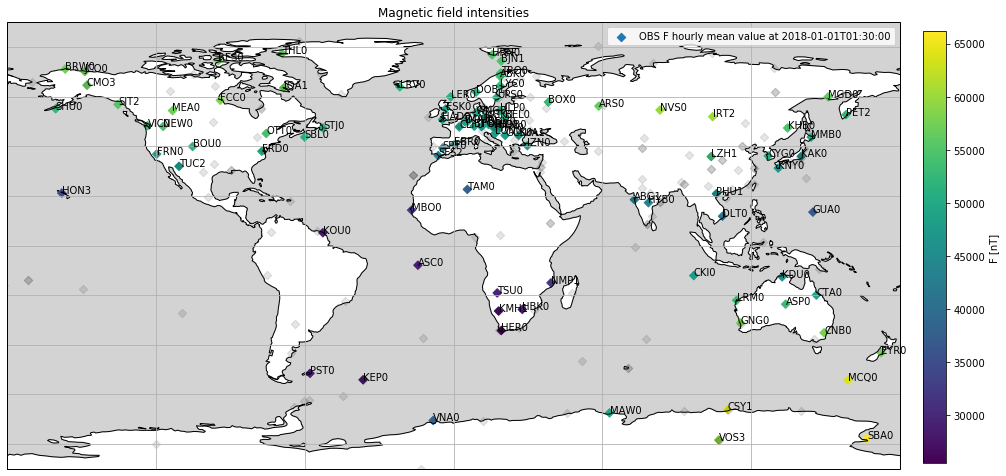

In [18]:
df = ascii_to_pandas(file1)

# Add F column
df['F'] = np.linalg.norm(df[['B_N', 'B_E', 'B_C']], axis=1)

# Select date
date = '2018-01-01T01:30:00'

fig = plt.figure(figsize=(16, 10))

# Draw map
ax = plt.subplot2grid((1, 1), (0, 0), projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
ax.gridlines()

# Plot observatory measurements at date
cm = ax.scatter(
    df[date]['Longitude'], df[date]['Latitude'], c=df[date]['F'],
    marker='D', transform=ccrs.PlateCarree(),
    label=f'OBS F hourly mean value at {date}'
)

# Add IAGA codes
for row in df[date].itertuples():
    ax.annotate(
        row.IAGA_code, (row.Longitude, row.Latitude),
        xycoords=ccrs.PlateCarree()._as_mpl_transform(ax)
    )

# Add missing observatories from obslist (position only)
missing = obs[~obs['IAGA_code'].isin(df[date]['IAGA_code'].unique())]
cm2 = ax.scatter(missing['Longitude'], missing['Latitude'], c='black', marker='D', alpha=0.1)

# Set title and legendbb
plt.title('Magnetic field intensities')
plt.legend()

# Add colorbar
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
plt.colorbar(cm, cax=cax, label='F [nT]')

plt.show()

Add Swarm F measurements between 01:00:00 and 02:00:00 of the same day:

In [19]:
# using viresclient
request = SwarmRequest()
request.set_collection('SW_OPER_MAGA_LR_1B')
request.set_products(measurements='F')

start_date = '2018-01-01T01:00:00'
end_date = '2018-01-01T02:00:00'

data = request.get_between(start_date, end_date)

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.157MB)


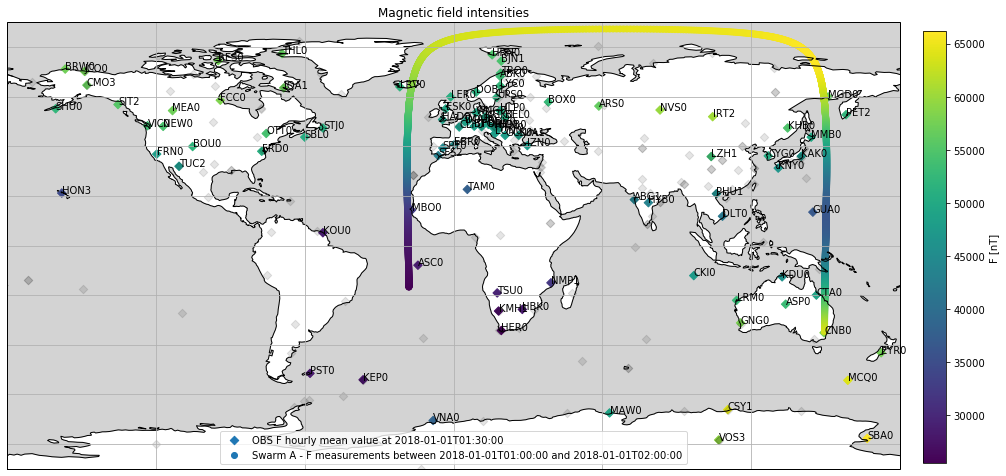

In [20]:
df = ascii_to_pandas(file1)

# Add F column
df['F'] = np.linalg.norm(df[['B_N', 'B_E', 'B_C']], axis=1)

# Select date
date = '2018-01-01T01:30:00'

fig = plt.figure(figsize=(16, 10))

# Draw map
ax = plt.subplot2grid((1, 1), (0, 0), projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
ax.gridlines()

# Plot observatory measurements at date
cm = ax.scatter(
    df[date]['Longitude'], df[date]['Latitude'], c=df[date]['F'],
    marker='D', transform=ccrs.PlateCarree(),
    label=f'OBS F hourly mean value at {date}'
)

# Add IAGA codes
for row in df[date].itertuples():
    ax.annotate(
        row.IAGA_code, (row.Longitude, row.Latitude),
        xycoords=ccrs.PlateCarree()._as_mpl_transform(ax)
    )

# Add missing observatories from obslist (position only)
missing = obs[~obs['IAGA_code'].isin(df[date]['IAGA_code'].unique())]
ax.scatter(missing['Longitude'], missing['Latitude'], c='black', marker='D', alpha=0.1)

# Add Swarm A data
swarm = data.as_dataframe()
ax.scatter(
    swarm['Longitude'], swarm['Latitude'], c=swarm['F'],
    transform=ccrs.PlateCarree(),
    label=f'Swarm A - F measurements between {start_date} and {end_date}'
)

# Set title and legendbb
plt.title('Magnetic field intensities')
plt.legend()

# Add colorbar
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
plt.colorbar(cm, cax=cax, label='F [nT]')

plt.show()

<a id="obsms" />

## Minute and second mean values

[[TOP]](#top)

Files containing observatory minute and second mean values have CDF format. They can be downloade from:

- ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/
- ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/second/

<a id="obsms-read-cdf" />

### Read data from CDF files

[[TOP]](#top)

Use the `search()` function (see [Settings and functions](#settings)) to search OBS minute/second data from 2019-12-01T00:00:00 to 2019-12-31T23:59:59 on the FTP server:

In [21]:
minute = search('minute', '2019-12-01', '2019-12-31T23:59:59')
minute

['/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191201T000000_20191201T235959_0102.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191202T000000_20191202T235959_0102.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191203T000000_20191203T235959_0103.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191204T000000_20191204T235959_0102.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191205T000000_20191205T235959_0103.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191206T000000_20191206T235959_0105.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191207T000000_20191207T235959_0103.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191208T000000_20191208T235959_0103.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191209T000000_20191209T235959_0103.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191210T000000_20191210T235959_0103.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191211T000000_2019

In [22]:
second = search('second', '2019-12-01', '2019-12-31T23:59:59')
second

['/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191201T000000_20191201T235959_0102.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191202T000000_20191202T235959_0102.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191203T000000_20191203T235959_0102.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191204T000000_20191204T235959_0102.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191205T000000_20191205T235959_0102.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191206T000000_20191206T235959_0101.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191207T000000_20191207T235959_0101.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191208T000000_20191208T235959_0101.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191209T000000_20191209T235959_0102.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191210T000000_20191210T235959_0102.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191211T000000_2019

Use the `download()` function (see [Settings and functions](#settings)) to download data:

In [23]:
dl_minute = download(minute, outdir=OBS_MINUTE_LOCAL_DIR)

SW_OPER_AUX_OBSM2__20191201T000000_20191201T235959_0102.ZIP: 100%|██████████| 1.15M/1.15M [00:00<00:00, 1.47MB/s]
SW_OPER_AUX_OBSM2__20191202T000000_20191202T235959_0102.ZIP: 100%|██████████| 1.09M/1.09M [00:00<00:00, 1.31MB/s]
SW_OPER_AUX_OBSM2__20191203T000000_20191203T235959_0103.ZIP: 100%|██████████| 1.13M/1.13M [00:00<00:00, 1.42MB/s]
SW_OPER_AUX_OBSM2__20191204T000000_20191204T235959_0102.ZIP: 100%|██████████| 1.14M/1.14M [00:00<00:00, 1.44MB/s]
SW_OPER_AUX_OBSM2__20191205T000000_20191205T235959_0103.ZIP: 100%|██████████| 1.12M/1.12M [00:00<00:00, 1.37MB/s]
SW_OPER_AUX_OBSM2__20191206T000000_20191206T235959_0105.ZIP: 100%|██████████| 1.16M/1.16M [00:00<00:00, 1.31MB/s]
SW_OPER_AUX_OBSM2__20191207T000000_20191207T235959_0103.ZIP: 100%|██████████| 1.10M/1.10M [00:00<00:00, 1.36MB/s]
SW_OPER_AUX_OBSM2__20191208T000000_20191208T235959_0103.ZIP: 100%|██████████| 1.16M/1.16M [00:00<00:00, 1.49MB/s]
SW_OPER_AUX_OBSM2__20191209T000000_20191209T235959_0103.ZIP: 100%|██████████| 1.16M/1.16

In [24]:
dl_second = download(second, outdir=OBS_SECOND_LOCAL_DIR)

SW_OPER_AUX_OBSS2__20191201T000000_20191201T235959_0102.ZIP: 100%|██████████| 6.80M/6.80M [00:03<00:00, 1.99MB/s]
SW_OPER_AUX_OBSS2__20191202T000000_20191202T235959_0102.ZIP: 100%|██████████| 6.20M/6.20M [00:03<00:00, 1.99MB/s]
SW_OPER_AUX_OBSS2__20191203T000000_20191203T235959_0102.ZIP: 100%|██████████| 6.28M/6.28M [00:03<00:00, 2.09MB/s]
SW_OPER_AUX_OBSS2__20191204T000000_20191204T235959_0102.ZIP: 100%|██████████| 6.44M/6.44M [00:03<00:00, 2.10MB/s]
SW_OPER_AUX_OBSS2__20191205T000000_20191205T235959_0102.ZIP: 100%|██████████| 6.16M/6.16M [00:03<00:00, 1.98MB/s]
SW_OPER_AUX_OBSS2__20191206T000000_20191206T235959_0101.ZIP: 100%|██████████| 5.35M/5.35M [00:02<00:00, 2.05MB/s]
SW_OPER_AUX_OBSS2__20191207T000000_20191207T235959_0101.ZIP: 100%|██████████| 5.18M/5.18M [00:02<00:00, 1.98MB/s]
SW_OPER_AUX_OBSS2__20191208T000000_20191208T235959_0101.ZIP: 100%|██████████| 5.15M/5.15M [00:02<00:00, 2.04MB/s]
SW_OPER_AUX_OBSS2__20191209T000000_20191209T235959_0102.ZIP: 100%|██████████| 6.49M/6.49

Select one of the AUX_OBSM2_ files (e.g. the first one):

In [25]:
file1 = dl_minute[0]
file1

PosixPath('/home/jovyan/data/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191201T000000_20191201T235959_0102.DBL')

Read CDF file using `cdflib` (for more information on `cdflib`, see: https://github.com/MAVENSDC/cdflib)

In [26]:
data = cdflib.CDF(file1)

Get info about the file as a Python dictionary:

In [27]:
data.cdf_info()

{'CDF': PosixPath('/tmp/tmp0pnh11fq.cdf'),
 'Version': '3.6.3',
 'Encoding': 6,
 'Majority': 'Row_major',
 'rVariables': [],
 'zVariables': ['IAGA_code',
  'Quality',
  'Timestamp',
  'Longitude',
  'Latitude',
  'Radius',
  'B_NEC'],
 'Attributes': [{'TITLE': 'Global'},
  {'ACKNOWLEDGMENTS': 'Global'},
  {'UNITS': 'Variable'},
  {'DESCRIPTION': 'Variable'},
  {'FORMAT': 'Variable'}],
 'Copyright': '\nCommon Data Format (CDF)\n(C) Copyright 1990-2016 NASA/GSFC\nSpace Physics Data Facility\nNASA/Goddard Space Flight Center\nGreenbelt, Maryland 20771 USA\n(Internet -- GSFC-CDF-SUPPORT@LISTS.NASA.GOV)\n',
 'Checksum': False,
 'Num_rdim': 0,
 'rDim_sizes': [],
 'Compressed': True,
 'LeapSecondUpdated': 20170101}

You can see that measurements are stored as *zVariables*:

In [28]:
data.cdf_info()['zVariables']

['IAGA_code',
 'Quality',
 'Timestamp',
 'Longitude',
 'Latitude',
 'Radius',
 'B_NEC']

Data can be retrieved via the `.varget()` method, e.g:

In [29]:
data.varget('B_NEC')

array([[11132.06964493,  1858.6       , 52140.59272103],
       [11131.66941554,  1858.        , 52140.69179895],
       [11130.06780661,  1858.5       , 52141.38810983],
       ...,
       [20864.32347092,  1637.83      , 43973.79061713],
       [20864.24347136,  1637.79      , 43973.79034978],
       [20864.02347259,  1637.77      , 43973.78961458]])

Data is returned as a `numpy.ndarray` object (for more information on `numpy.ndarray`, see: https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html).

Variable attributes can be retrieved using the `.varattsget()` method, e.g.:

In [30]:
data.varattsget('B_NEC')

{'UNITS': 'nT',
 'DESCRIPTION': 'Geocentric-north, east, and geocentric-down component of magnetic field.  NaN values are used as placeholders for missing data.',
 'FORMAT': 'F8.1'}

Attributes are returned as a Python dictionary.

Let's retrieve the timestamps:

In [31]:
data.varget('Timestamp')

array([6.37423776e+13, 6.37423777e+13, 6.37423777e+13, ...,
       6.37424638e+13, 6.37424639e+13, 6.37424639e+13])

`Timestamp` type is:

In [32]:
data.varget('Timestamp').dtype

dtype('float64')

Timestamps are represented as NumPy `float64` values. Why? Get info about `Timestamp` variable using the `.varinq()` method:

In [33]:
data.varinq('Timestamp')

{'Variable': 'Timestamp',
 'Num': 2,
 'Var_Type': 'zVariable',
 'Data_Type': 31,
 'Data_Type_Description': 'CDF_EPOCH',
 'Num_Elements': 1,
 'Num_Dims': 0,
 'Dim_Sizes': [],
 'Sparse': 'No_sparse',
 'Last_Rec': 80639,
 'Rec_Vary': True,
 'Dim_Vary': [],
 'Pad': array([0.]),
 'Compress': 0,
 'Block_Factor': 0}

The returned dictionary shows that the data type is *CDF_EPOCH* consising in a floating point value representing the number of milliseconds since 01-Jan-0000 00:00:00.000. It can be converted to a more readable format (list of strings) using the `cdflib.cdfepoch.encode()` function:

In [34]:
ts = cdflib.cdfepoch.encode(data.varget('Timestamp'), iso_8601=True)
ts[:5]

['2019-12-01T00:00:00.000',
 '2019-12-01T00:01:00.000',
 '2019-12-01T00:02:00.000',
 '2019-12-01T00:03:00.000',
 '2019-12-01T00:04:00.000']

Or to a numpy array of `numpy.datetime64` values:

In [35]:
ts = np.array(cdflib.cdfepoch.encode(data.varget('Timestamp'), iso_8601=True), dtype='datetime64')
ts[:5]

array(['2019-12-01T00:00:00.000', '2019-12-01T00:01:00.000',
       '2019-12-01T00:02:00.000', '2019-12-01T00:03:00.000',
       '2019-12-01T00:04:00.000'], dtype='datetime64[ms]')

You may be interested also in the CDF global attributes:

In [36]:
data.globalattsget()

{'TITLE': 'ESA Swarm level 2 auxiliary product: observatory definitive and/or quasi-definitive minute-mean data (AUX_OBSM2_)',
 'ACKNOWLEDGMENTS': 'The data presented in this product rely on data collected at magnetic observatories. We thank the national institutes that support them and INTERMAGNET for promoting high standards of magnetic observatory practice (www.intermagnet.org).'}

Close the file when you have finished:

In [37]:
data.close()

AUX_OBSS2_ data contains the same variables:

In [38]:
with closing(cdflib.cdfread.CDF(dl_second[0])) as data:
    zvariables = data.cdf_info()['zVariables']

zvariables

['IAGA_code',
 'Quality',
 'Timestamp',
 'Longitude',
 'Latitude',
 'Radius',
 'B_NEC']

Data can be represented as a `pandas.DataFrame` object:

In [39]:
with closing(cdflib.cdfread.CDF(file1)) as data:
    ts = pd.DatetimeIndex(
            cdflib.cdfepoch.encode(data.varget('Timestamp'), iso_8601=True),
            name='Timestamp'
        )
    df1 = pd.DataFrame(
        {
            'IAGA_code': data.varget('IAGA_code')[:,0,0],
            'Latitude': data.varget('Latitude'),
            'Longitude': data.varget('Longitude'),
            'Radius': data.varget('Radius'),
            'B_N': data.varget('B_NEC')[:,0],
            'B_E': data.varget('B_NEC')[:,1],
            'B_C': data.varget('B_NEC')[:,2]
        },
        index=ts
    )

df1

,IAGA_code,Latitude,Longitude,Radius,B_N,B_E,B_C
Timestamp,,,,,,,
2019-12-01 00:00:00,ABK,68.267960,18.8,6.360051e+06,11132.069645,1858.60,52140.592721
2019-12-01 00:01:00,ABK,68.267960,18.8,6.360051e+06,11131.669416,1858.00,52140.691799
2019-12-01 00:02:00,ABK,68.267960,18.8,6.360051e+06,11130.067807,1858.50,52141.388110
2019-12-01 00:03:00,ABK,68.267960,18.8,6.360051e+06,11130.366193,1858.90,52142.088799
2019-12-01 00:04:00,ABK,68.267960,18.8,6.360051e+06,11132.863421,1859.50,52143.294557
...,...,...,...,...,...,...,...
2019-12-01 23:55:00,WIC,47.708527,15.9,6.367496e+06,20864.393537,1637.75,43973.770851
2019-12-01 23:56:00,WIC,47.708527,15.9,6.367496e+06,20864.413537,1637.78,43973.770918
2019-12-01 23:57:00,WIC,47.708527,15.9,6.367496e+06,20864.323471,1637.83,43973.790617


For more information on `pandas.Dataframe` see: https://pandas.pydata.org/docs/reference/frame.

The same result can be obtained with the `cdf_to_pandas()` function (see [Settings and functions](#settings)).

In [40]:
new = cdf_to_pandas(file1)

new

,IAGA_code,Latitude,Longitude,Radius,B_N,B_E,B_C
Timestamp,,,,,,,
2019-12-01 00:00:00,ABK,68.267960,18.8,6.360051e+06,11132.069645,1858.60,52140.592721
2019-12-01 00:01:00,ABK,68.267960,18.8,6.360051e+06,11131.669416,1858.00,52140.691799
2019-12-01 00:02:00,ABK,68.267960,18.8,6.360051e+06,11130.067807,1858.50,52141.388110
2019-12-01 00:03:00,ABK,68.267960,18.8,6.360051e+06,11130.366193,1858.90,52142.088799
2019-12-01 00:04:00,ABK,68.267960,18.8,6.360051e+06,11132.863421,1859.50,52143.294557
...,...,...,...,...,...,...,...
2019-12-01 23:55:00,WIC,47.708527,15.9,6.367496e+06,20864.393537,1637.75,43973.770851
2019-12-01 23:56:00,WIC,47.708527,15.9,6.367496e+06,20864.413537,1637.78,43973.770918
2019-12-01 23:57:00,WIC,47.708527,15.9,6.367496e+06,20864.323471,1637.83,43973.790617


Compare the two data frames:

In [41]:
pd.testing.assert_frame_equal(df1, new)

Example: get minimum and maximum dates:

In [42]:
df1.index.min(), df1.index.max()

(Timestamp('2019-12-01 00:00:00'), Timestamp('2019-12-01 23:59:00'))

Example: get list of observatories (IAGA codes) stored in the files:

In [43]:
df1['IAGA_code'].unique()

array(['ABK', 'ASC', 'ASP', 'BEL', 'BOU', 'BOX', 'BRW', 'CKI', 'CLF',
       'CMO', 'CNB', 'CSY', 'CTA', 'CYG', 'DOU', 'EBR', 'ESK', 'FRD',
       'FRN', 'GNG', 'GUA', 'HAD', 'HER', 'HLP', 'HON', 'JCO', 'KAK',
       'KDU', 'KEP', 'KNY', 'LER', 'LON', 'LRM', 'LYC', 'MAB', 'MAW',
       'MBO', 'MCQ', 'MGD', 'MMB', 'NEW', 'NGK', 'NVS', 'PET', 'PIL',
       'PST', 'SBL', 'SFS', 'SHU', 'SIT', 'SJG', 'TAM', 'THY', 'TUC',
       'UPS', 'WIC'], dtype=object)

Example: get list of observatories (IAGA codes) included in the following ranges of coordinates:
- $30 \leq Latitude \leq 70$
- $-10 \leq Longitude \leq 40$

In [44]:
df1[(df1['Latitude'] >= 30) & (df1['Latitude'] <= 70) & (df1['Longitude'] >= -10) & (df1['Longitude'] <= 40)]['IAGA_code'].unique()

array(['ABK', 'BEL', 'BOX', 'CLF', 'DOU', 'EBR', 'HLP', 'LON', 'LYC',
       'MAB', 'NGK', 'THY', 'UPS', 'WIC'], dtype=object)

You can do the same using the `.query()` method (see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html#pandas.DataFrame.query):

In [45]:
df1.query('(30 <= Latitude <= 70) and (-10 <= Longitude <= 40)')['IAGA_code'].unique()

array(['ABK', 'BEL', 'BOX', 'CLF', 'DOU', 'EBR', 'HLP', 'LON', 'LYC',
       'MAB', 'NGK', 'THY', 'UPS', 'WIC'], dtype=object)

<a id="obsms-multifiles" />

### Read data from multiple files

[[TOP]](#top)

Pandas dataframes can be concatenated to represent data obtained from more than one file. E.g. read data from the next AUX_OBSM2_ file:

In [46]:
file2 = dl_minute[1]

df2 = cdf_to_pandas(file2)

df2

,IAGA_code,Latitude,Longitude,Radius,B_N,B_E,B_C
Timestamp,,,,,,,
2019-12-02 00:00:00,ABK,68.267960,18.8,6.360051e+06,11146.834346,1856.50,52155.926788
2019-12-02 00:01:00,ABK,68.267960,18.8,6.360051e+06,11146.933424,1856.50,52156.327017
2019-12-02 00:02:00,ABK,68.267960,18.8,6.360051e+06,11146.832963,1856.30,52156.526786
2019-12-02 00:03:00,ABK,68.267960,18.8,6.360051e+06,11146.033196,1855.90,52156.424943
2019-12-02 00:04:00,ABK,68.267960,18.8,6.360051e+06,11145.433428,1855.70,52156.323560
...,...,...,...,...,...,...,...
2019-12-02 23:55:00,WIC,47.708527,15.9,6.367496e+06,20862.879469,1638.98,43974.985798
2019-12-02 23:56:00,WIC,47.708527,15.9,6.367496e+06,20862.739436,1638.94,43974.995330
2019-12-02 23:57:00,WIC,47.708527,15.9,6.367496e+06,20862.829770,1639.21,43974.895632


The two dataframes can be concatenated using the `pandas.concat()` function (for more information see: https://pandas.pydata.org/docs/reference/api/pandas.concat.html#pandas.concat):

In [47]:
concatenated = pd.concat([df1, df2])
concatenated.sort_values(by=['IAGA_code', 'Timestamp'], inplace=True)

concatenated.index.min(), concatenated.index.max()

(Timestamp('2019-12-01 00:00:00'), Timestamp('2019-12-02 23:59:00'))

In [48]:
concatenated

,IAGA_code,Latitude,Longitude,Radius,B_N,B_E,B_C
Timestamp,,,,,,,
2019-12-01 00:00:00,ABK,68.267960,18.8,6.360051e+06,11132.069645,1858.60,52140.592721
2019-12-01 00:01:00,ABK,68.267960,18.8,6.360051e+06,11131.669416,1858.00,52140.691799
2019-12-01 00:02:00,ABK,68.267960,18.8,6.360051e+06,11130.067807,1858.50,52141.388110
2019-12-01 00:03:00,ABK,68.267960,18.8,6.360051e+06,11130.366193,1858.90,52142.088799
2019-12-01 00:04:00,ABK,68.267960,18.8,6.360051e+06,11132.863421,1859.50,52143.294557
...,...,...,...,...,...,...,...
2019-12-02 23:55:00,WIC,47.708527,15.9,6.367496e+06,20862.879469,1638.98,43974.985798
2019-12-02 23:56:00,WIC,47.708527,15.9,6.367496e+06,20862.739436,1638.94,43974.995330
2019-12-02 23:57:00,WIC,47.708527,15.9,6.367496e+06,20862.829770,1639.21,43974.895632


With AUX_OBSS2_ data:

In [49]:
files = dl_second[:2]

files

[PosixPath('/home/jovyan/data/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191201T000000_20191201T235959_0102.DBL'),
 PosixPath('/home/jovyan/data/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191202T000000_20191202T235959_0102.DBL')]

In [50]:
concatenated = pd.concat([cdf_to_pandas(file) for file in files])
concatenated.sort_values(by=['IAGA_code', 'Timestamp'], inplace=True)

concatenated.index.min(), concatenated.index.max()

(Timestamp('2019-12-01 00:00:00'), Timestamp('2019-12-02 23:59:59'))

In [51]:
concatenated

,IAGA_code,Latitude,Longitude,Radius,B_N,B_E,B_C
Timestamp,,,,,,,
2019-12-01 00:00:00,BOX,57.897002,38.23,6.362885e+06,14998.682932,3419.25,50631.477449
2019-12-01 00:00:01,BOX,57.897002,38.23,6.362885e+06,14998.713113,3419.26,50631.417540
2019-12-01 00:00:02,BOX,57.897002,38.23,6.362885e+06,14998.693143,3419.25,50631.407479
2019-12-01 00:00:03,BOX,57.897002,38.23,6.362885e+06,14998.773143,3419.29,50631.407721
2019-12-01 00:00:04,BOX,57.897002,38.23,6.362885e+06,14998.813143,3419.29,50631.407842
...,...,...,...,...,...,...,...
2019-12-02 23:59:55,WIC,47.708527,15.90,6.367496e+06,20862.650339,1639.76,43974.725031
2019-12-02 23:59:56,WIC,47.708527,15.90,6.367496e+06,20862.640372,1639.75,43974.714998
2019-12-02 23:59:57,WIC,47.708527,15.90,6.367496e+06,20862.640339,1639.75,43974.724998
